<a href="https://colab.research.google.com/github/NadAAaHH/SDAIA_T5_NLP_project/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Load and preprocess data

In [ ]:
import numpy as np 
import pandas as pd
import string as st
import re
import nltk
from nltk import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy import linalg
from wordcloud import WordCloud

In [ ]:
# run only once
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
df = pd.read_csv(r'C:\Users\Nadar\OneDrive\Desktop\SDAIA\NLP\appleStore_description.csv')
df_info = pd.read_csv(r'C:\Users\Nadar\OneDrive\Desktop\SDAIA\NLP\AppleStore.csv')

In [ ]:
df_info.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [ ]:
df_info = df_info[['id', 'track_name', 'user_rating', 'prime_genre']]

In [ ]:
df_info.head()

,id,track_name,user_rating,prime_genre
0,281656475,PAC-MAN Premium,4.0,Games
1,281796108,Evernote - stay organized,4.0,Productivity
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",3.5,Weather
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",4.0,Shopping
4,282935706,Bible,4.5,Reference


In [ ]:
# take only the apps that have a rating above 4 then sort by ratings
df_filtered = df_info[df_info.user_rating > 4].sort_values(by=['user_rating'], ascending=False)

In [ ]:
print(df_filtered['prime_genre'].value_counts())

Games                1941
Photo & Video         184
Education             158
Entertainment         144
Health & Fitness      105
Productivity           91
Utilities              74
Music                  64
Shopping               53
Book                   44
Social Networking      41
Lifestyle              37
Travel                 29
Reference              29
Weather                26
Business               26
Finance                24
Sports                 21
Food & Drink           21
Navigation             14
News                   14
Medical                13
Catalogs                2
Name: prime_genre, dtype: int64


In [ ]:
# merge Entertainment and Games
df_filtered['prime_genre'] = df_filtered['prime_genre'].apply(lambda x : 'Entertainment' if x == 'Games' else x)
# merge Productivity and Utilities
df_filtered['prime_genre'] = df_filtered['prime_genre'].apply(lambda x : 'Productivity' if x == 'Utilities' else x)
# merge Finance and Business
df_filtered['prime_genre'] = df_filtered['prime_genre'].apply(lambda x : 'Business' if x == 'Finance' else x)
# merge Book and Reference
df_filtered['prime_genre'] = df_filtered['prime_genre'].apply(lambda x : 'Book' if x == 'Reference' else x)
# merge Book and Reference
df_filtered['prime_genre'] = df_filtered['prime_genre'].apply(lambda x : 'Book' if x == 'Reference' else x)

In [ ]:
# remove all apps of minimum genre
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Lifestyle']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Catalogs']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Medical']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Navigation']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'News']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Business']
df_filtered = df_filtered[df_filtered['prime_genre'] != 'Entertainment']

In [ ]:
print(df_filtered['prime_genre'].value_counts())

Photo & Video        184
Productivity         165
Education            158
Health & Fitness     105
Book                  73
Music                 64
Shopping              53
Social Networking     41
Travel                29
Weather               26
Food & Drink          21
Sports                21
Name: prime_genre, dtype: int64


In [ ]:
# get only apps that exsit after filtering
df = df[df['id'].isin(list(df_filtered['id']))]

In [ ]:
# due to their diversity, exclude all apps of Games genre
df_filtered = df_filtered.reset_index()
df = df.reset_index()

In [ ]:
df_filtered.shape

(940, 5)

In [ ]:
df.shape

(940, 5)

In [ ]:
topics = list(df_filtered['prime_genre'].unique())
print(topics)

['Productivity', 'Photo & Video', 'Education', 'Music', 'Book', 'Health & Fitness', 'Social Networking', 'Shopping', 'Travel', 'Food & Drink', 'Sports', 'Weather']


In [ ]:
for i in range(10):
    print(df['app_desc'][i])
    print('*' * 50)

SAVE 20%, now only $3.99 for a limited time!

One of the most popular video games in arcade history!
2015 World Video Game Hall of Fame Inductee

Who can forget the countless hours and quarters spent outrunning pesky ghosts and chompin’ on dots? Now you can have the same arcade excitement on your mobile devices! 
Guide PAC-MAN through the mazes with easy swipe controls, a MFi controller, or kick it old school with the onscreen joystick!
Eat all of the dots to advance to the next stage. Go for high scores and higher levels! Gain an extra life at 10.000 points! Gobble Power Pellets to weaken ghosts temporarily and eat them up before they change back. Avoid Blinky, the leader of the ghosts, and his fellow ghosts Pinky, Inky, and Clyde, or you will lose a life. It’s game over when you lose all your lives.

9 NEW MAZES Included!!!
The game includes 9 new mazes in addition to the pixel for pixel recreation of the classic original maze. Challenge your skill to beat them all! We are constantly

### Text cleaning and processing steps
1. Remove URLs
2. Remove punctuations  
3. Remove non-alphanumeric characters
4. Lower casing
5. Convert text to tokens  
6. Remove stopwords using NLTK corpus stopwords list to match    
7. Apply lemmatization  
8. Convert words to feature vectors

In [ ]:
print('Before: \n', df['app_desc'][1])
print('*' * 50)
print('After: \n', precosseing_pipeline(df['app_desc'][1]))

Before: 
 Let Evernote change the way you organize your personal and professional projects. Dive in: take notes, create to-do lists, and save things you find online into Evernote. We’ll sync everything between your phone, tablet, and computer automatically.

---

“Use Evernote as the place you put everything… Don’t ask yourself which device it’s on—it’s in Evernote” – The New York Times

“When it comes to taking all manner of notes and getting work done, Evernote is an indispensable tool.” – PC Mag

---

GET ORGANIZED
Evernote gives you the tools you need to keep your work effortlessly organized:
• Write, collect and capture ideas as searchable notes, notebooks, checklists and to-do lists
• Take notes in a variety of formats, including: text, sketches, photos, audio, video, PDFs, web clippings and more
• Use the camera to effortlessly scan, digitize, and organize your paper documents, business cards, handwritten notes and drawings
• Use Evernote as a digital notepad and easy-to-format 

In [ ]:
def precosseing_pipeline(text):
    if detect('convert words to feature vectors') == 'en':
        # remove urls
        text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', ' ', text)
        # remove punctuations 
        text = ("".join([ch for ch in text if ch not in st.punctuation]))
        # remove non-alphanumeric characters
        text = re.sub(r'[^a-zA-Z]', ' ', text)
        # lower casing
        text = text.lower()
        # convert text to tokens
        text = re.split('\s+' ,text)
        tokens = [x.lower() for x in text]
        # remove stopwords using NLTK corpus stopwords list to match
        tokens = [word for word in text if word not in nltk.corpus.stopwords.words('english')]
        # apply lemmatization
        word_net = WordNetLemmatizer()
        tokens = [word_net.lemmatize(word) for word in tokens]
        # convert words to feature vectors
        text = " ".join([word for word in tokens])
    else:
        text = np.nan
        
    return text

In [ ]:
df['processed_desc'] = df['app_desc'].apply(lambda x : precosseing_pipeline(x) if len(precosseing_pipeline(x)) > 100 else np.nan)

In [ ]:
df.head()

,index,id,track_name,size_bytes,app_desc,processed_desc
0,4,282935706,Bible,92774400,On more than 250 million devices around the wo...,million device around world people reading lis...
1,8,284666222,PCalc - The Best Calculator,49250304,"PCalc is the powerful choice for scientists, e...",pcalc powerful choice scientist engineer stude...
2,20,285946052,iQuran,70707916,** iPray for Mac OS X is OUT **\n\n***********...,ipray mac o x news iquran sold fraction origi...
3,31,289084315,Period Tracker Deluxe,40216576,"Period Tracker, the easiest way to track your ...",period tracker easiest way track health suppor...
4,38,291430598,Hurricane Pro,29518848,Hurricane Pro: The best Hurricane tracker app ...,hurricane pro best hurricane tracker app iphon...


In [ ]:
# explore null values 
df[list(df.columns)].isnull().sum()

index              0
id                 0
track_name         0
size_bytes         0
app_desc           0
processed_desc    66
dtype: int64

In [ ]:
# drop NaNs
df = df.dropna()

In [ ]:
# explore null values 
df[list(df.columns)].isnull().sum()

index             0
id                0
track_name        0
size_bytes        0
app_desc          0
processed_desc    0
dtype: int64

In [ ]:
df.shape

(874, 6)

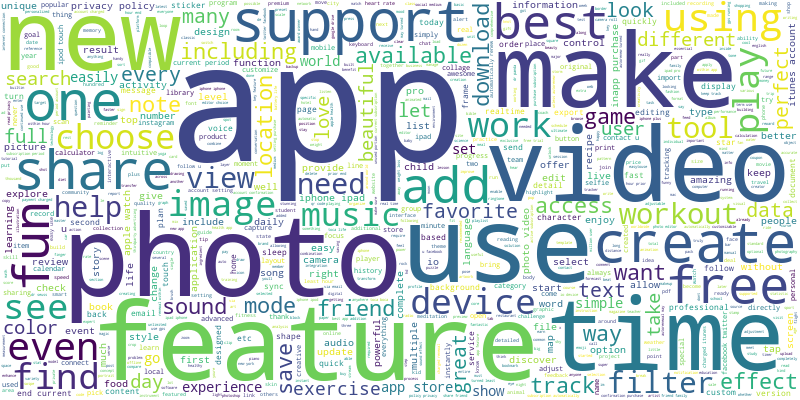

In [ ]:
# Join the different processed titles together.
long_string = ','.join(list(df['processed_desc'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
df['processed_desc'] = df['processed_desc'].apply(lambda x : re.sub('game | play | app | use | feature | new | make | apps | time | subscription', '', x))

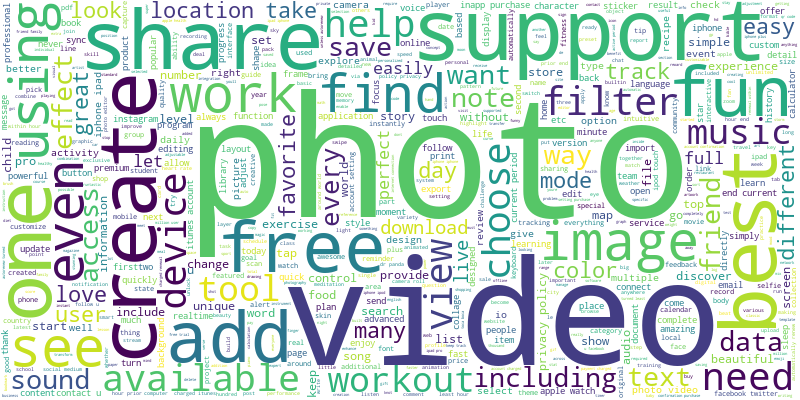

In [ ]:
# Join the different processed titles together.
long_string = ','.join(list(df['processed_desc'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Try LSA

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
# Define CountVectorizer
cv = CountVectorizer(stop_words='english')

# Apply it to the dataset
document_word_matrix = cv.fit_transform(df["processed_desc"]).todense()

# Print the result
print(document_word_matrix.shape)

(874, 20987)


In [ ]:
# apply SVD to our Document-Word-Matrix
U, s, Vh = linalg.svd(document_word_matrix, full_matrices=False)

In [ ]:
print('Shape of U', U.shape)
print('Shape of s', s.shape)
print('Shape of Vh', Vh.shape)

Shape of U (874, 874)
Shape of s (874,)
Shape of Vh (874, 20987)


In [ ]:
num_top_words = 10

vocab = np.array(cv.get_feature_names())

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [ ]:
print(vocab[5000:5020])

['chaines' 'chaining' 'chainreaction' 'chainsaw' 'chainsmokers'
 'chainsword' 'chair' 'chairgames' 'chairman' 'chakra' 'chalet' 'chalice'
 'chalk' 'challanges' 'challenge' 'challengeaddictive'
 'challengeartistobattle' 'challengebadge' 'challengecharacter'
 'challengecompletely']


In [ ]:
print('\n'.join(show_topics(Vh[:12])))

photo video share create iphone ipad free like add effect
photo video collage filter effect camera frame instagram editing sticker
video workout music exercise audio clip song fitness hd sound
weather video forecast map alert radar current location storm data
file ipad pdf text document iphone sound support device weather
kid fun child toca weather privacy video learn world story
file account free pdf period document privacy purchase current text
sleep music sound period account song meditation end free charged
music sound weather file sleep pdf meditation song text document
sleep food life toca recipe share day product health friend
number math event food sleep recipe reminder calendar data list
event calendar reminder create add week fantastical text word image


################

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re

In [ ]:
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')

tfidf = TfidfVectorizer(lowercase=True,
                        min_df=10
                       )

X = tfidf.fit_transform(df['processed_desc'])
print(X.shape)

(874, 2072)


In [ ]:
lsa_obj = TruncatedSVD(n_components=12, n_iter=100, random_state=42)
tfidf_lsa_data = lsa_obj.fit_transform(X)

(874, 12)


In [ ]:
term_topic_matrix = pd.DataFrame(data=lsa.components_, 
                                 index = topics
                                )

In [ ]:
term_topic_matrix

,0,1,2,3,4,5,6,7,8,9,...,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958
Productivity,0.003861,0.009150,0.006220,0.023600,0.012821,0.011702,0.004053,0.057164,0.007205,0.007112,...,0.012581,0.011712,0.019061,0.010528,0.019797,0.019198,0.008799,0.004884,0.004403,0.025410
Photo & Video,-0.000576,-0.021136,-0.010502,-0.013277,-0.005772,-0.010873,-0.008616,-0.039480,-0.004177,-0.005416,...,-0.016420,-0.021148,-0.004239,-0.013287,-0.002856,0.009778,-0.005878,-0.001697,-0.006753,0.021047
Education,-0.000373,0.040172,-0.013617,0.008339,-0.000398,-0.000313,-0.021352,0.018089,-0.004543,-0.009796,...,0.025666,0.029911,-0.005830,-0.030954,-0.000245,0.001454,-0.001413,-0.001448,0.007449,0.001845
Music,0.004879,-0.029633,0.000596,-0.011514,0.001261,-0.013892,-0.015158,0.038389,0.011985,-0.002861,...,-0.006040,-0.022549,-0.003494,-0.017773,0.003351,-0.005797,-0.002213,0.011074,-0.001763,0.008353
Book,-0.008671,0.002315,0.004957,0.000394,-0.008439,0.002813,0.002081,-0.037950,-0.003704,0.005945,...,0.004463,-0.001712,0.007586,0.006020,0.001428,-0.030134,0.007653,-0.015214,0.003513,-0.004615
Health & Fitness,-0.002114,-0.025182,-0.003015,-0.027027,0.004935,-0.001203,-0.007582,-0.004978,-0.013742,-0.003030,...,0.021110,-0.014932,0.005240,0.000048,-0.009271,0.036027,-0.003687,-0.010542,-0.002701,-0.009203
Social Networking,-0.001358,0.032847,0.004864,0.012171,-0.000274,0.002723,0.008564,-0.036996,0.004972,-0.006347,...,-0.024977,0.017136,-0.009138,0.006726,-0.011688,0.028528,0.000049,-0.002984,-0.001715,0.015457
Shopping,-0.003706,0.001748,-0.002929,-0.017149,-0.001264,0.004490,-0.006095,0.022280,-0.004403,0.013580,...,-0.010650,0.000822,0.006771,-0.009690,0.011588,0.013146,0.008831,0.011065,-0.000390,-0.007766
Travel,-0.000721,-0.006384,0.006358,-0.000282,0.009993,-0.001302,0.034716,0.029757,0.004910,-0.021477,...,0.019260,-0.018329,-0.006251,0.005828,-0.000305,-0.008457,-0.008629,0.012543,-0.000512,0.003086
Food & Drink,-0.007927,-0.005015,-0.001318,0.000789,0.007170,-0.003403,-0.018145,-0.009000,0.021101,0.003428,...,0.005053,-0.006718,0.000318,0.000626,0.004778,0.006117,-0.000474,-0.012739,-0.001983,0.017548


In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

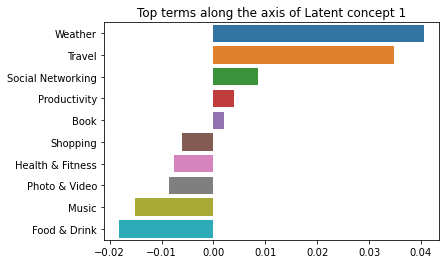

In [ ]:
data = term_topic_matrix[6]
data = data.sort_values(ascending=False)
top_10 = data[:10]
plt.title('Top terms along the axis of Latent concept 1')
fig = sns.barplot(x= top_10.values, y=top_10.index)

In [ ]:
lsa = TruncatedSVD(12)
doc_topic = lsa.fit_transform(X)
lsa.explained_variance_ratio_

array([0.00756876, 0.02210336, 0.01625066, 0.01376968, 0.01264107,
       0.0122516 , 0.01096845, 0.00982424, 0.00944101, 0.00895945,
       0.00861977, 0.0080434 ])

In [ ]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = topics,
             columns = cv.get_feature_names())
topic_word

ValueError: Shape of passed values is (12, 1959), indices imply (12, 20987)

In [ ]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
display_topics(lsa, tfidf.get_feature_names(), 10)


Topic  0
online, totally, duration, extended, rotation, measure, incredibly, converted, stepbystep, fire

Topic  1
online, totally, extended, class, duration, build, finish, idea, hear, drink

Topic  2
unlike, enjoy, fall, totally, online, supported, turn, offering, outlook, account

Topic  3
true, line, exposure, file, increase, album, la, powerspark, touch, simplicity

Topic  4
true, online, file, line, class, powerspark, la, album, curious, simplicity

Topic  5
totally, measure, offering, true, account, send, cover, care, editing, guided

Topic  6
totally, true, unlike, enjoy, file, separate, fall, line, simplicity, duration

Topic  7
totally, feedback, currency, safety, industry, prior, place, similar, said, reliable

Topic  8
universal, exposure, roll, totally, true, offering, diary, account, active, stepbystep

Topic  9
browser, browse, totally, bring, rendering, missing, back, little, emojis, male

Topic  10
exposure, instant, navigation, structure, physic, increase, diary, pap

### Try LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV

In [ ]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                            )

data_vectorized = vectorizer.fit_transform(df['processed_desc'])

In [ ]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=12,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,       # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=12, n_jobs=-1,
                          random_state=100)


In [ ]:
# Define Search Param
search_params = {'n_components': [10, 12, 15, 20], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 12, 15, 20]})

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -173967.50510783773
Model Perplexity:  882.6686821200889


In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,free,music,card,best,friend,store,share,favorite,song,deal
Topic 1,video,food,recipe,add,friend,share,meal,free,music,family
Topic 2,event,calendar,reminder,work,support,data,contact,email,apple,day
Topic 3,kid,fun,privacy,learn,child,world,story,learning,word,award
Topic 4,star,number,sky,math,map,moon,student,location,word,data
Topic 5,photo,filter,share,camera,collage,effect,fun,instagram,video,add
Topic 6,workout,weather,period,current,account,exercise,hour,purchase,end,track
Topic 7,sound,music,sleep,audio,meditation,state,radio,live,iphone,beat
Topic 8,file,ipad,device,support,text,note,iphone,document,pdf,language
Topic 9,image,photo,tool,color,mode,ipad,filter,effect,create,editing


### Try NMF

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# use tfidf by removing tokens that don't appear in at least 50 documents
vect = TfidfVectorizer(min_df=10, stop_words='english')
 
# Fit and transform
X = vect.fit_transform(df['processed_desc'])

In [ ]:
# Create an NMF instance: model
# the 14 components will be the topics
model = NMF(n_components=12, random_state=5)
 
# Fit the model to TF-IDF
model.fit(X)
 
# Transform the TF-IDF: nmf_features
nmf_features = model.transform(X)

C:\Users\Nadar\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [ ]:
X.shape

(874, 1959)

In [ ]:
nmf_features.shape

(874, 12)

In [ ]:
model.components_.shape

(12, 1959)

In [ ]:
components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names())
components_df

,aac,ab,abc,ability,able,absolutely,academic,access,accessible,accessory,...,yearly,yoga,youll,young,youre,youtube,youve,zip,zone,zoom
0,0.000000,0.000000,0.000000,0.047015,0.003751,0.011357,0.000000,0.000000,0.000000,0.003702,...,0.007280,0.000000,0.040089,0.000000,0.038788,0.000000,0.014625,0.000000,0.002282,0.086551
1,0.000000,0.133351,0.000000,0.069366,0.003195,0.032734,0.000000,0.035333,0.000000,0.000000,...,0.027448,0.101295,0.000769,0.000000,0.008812,0.000000,0.014221,0.000000,0.019186,0.000000
2,0.000000,0.000000,0.003412,0.009722,0.004505,0.030810,0.000000,0.000000,0.003002,0.031310,...,0.000000,0.000000,0.019291,0.050913,0.003966,0.011639,0.018269,0.000036,0.000000,0.000056
3,0.024815,0.000000,0.000000,0.033523,0.016344,0.001906,0.000000,0.157602,0.027778,0.002875,...,0.000000,0.000000,0.000000,0.000000,0.033010,0.000000,0.000000,0.069330,0.003528,0.026004
4,0.000000,0.000000,0.020157,0.010713,0.002913,0.000000,0.000000,0.020230,0.016771,0.000000,...,0.001655,0.000000,0.000402,0.000000,0.000000,0.000000,0.009413,0.000000,0.004023,0.008924
5,0.003920,0.000000,0.000000,0.000000,0.026217,0.006195,0.000000,0.114600,0.000814,0.000000,...,0.093622,0.000000,0.020355,0.000224,0.012580,0.000000,0.000000,0.000000,0.011280,0.000000
6,0.000000,0.005306,0.000000,0.000000,0.028504,0.005904,0.000000,0.043837,0.000000,0.000000,...,0.000134,0.011890,0.010336,0.000000,0.007930,0.135502,0.000000,0.000000,0.000000,0.058386
7,0.000000,0.000000,0.013543,0.004292,0.004026,0.011048,0.000000,0.089591,0.000000,0.028263,...,0.000000,0.005554,0.030765,0.000000,0.036302,0.000000,0.021508,0.000067,0.006514,0.000000
8,0.013441,0.000000,0.001855,0.020506,0.002719,0.007685,0.000000,0.027843,0.000000,0.000000,...,0.000000,0.019714,0.011957,0.005387,0.001474,0.031422,0.003887,0.000000,0.000000,0.000000
9,0.000000,0.007375,0.002153,0.014090,0.005474,0.000000,0.000000,0.014739,0.045489,0.000077,...,0.000000,0.000000,0.000000,0.003101,0.002648,0.000000,0.001814,0.000000,0.000000,0.034082


In [ ]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
photo      2.305626
collage    0.657377
filter     0.649538
effect     0.536287
image      0.427516
tool       0.420598
color      0.412347
camera     0.403431
frame      0.379860
sticker    0.356235
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
workout      1.354592
exercise     0.698770
fitness      0.551719
training     0.304595
weight       0.260015
plan         0.231257
body         0.229453
minute       0.216731
goal         0.214169
runtastic    0.210093
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
kid          0.674232
panda        0.408466
toca         0.397771
privacy      0.380302
dr           0.289736
fun          0.245647
child        0.235427
adventure    0.230206
world        0.225942
animal       0.215886
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
file        0.933191
document    0.540910
pdf         0.480697
ipad        0.43776

In [ ]:
topics

['Entertainment',
 'Productivity',
 'Photo & Video',
 'Business',
 'Education',
 'Music',
 'Book',
 'Health & Fitness',
 'Social Networking',
 'Shopping',
 'Travel',
 'Food & Drink',
 'Sports',
 'Weather']

In [ ]:
df_filtered[df_filtered['prime_genre'] == 'Shopping'].head(20)

,index,id,track_name,user_rating,prime_genre
39,5335,1080248000,Romwe shopping- Fashion Clothing for women,5.0,Shopping
138,1435,544118997,"Shopular Coupons, Weekly Deals for Target, Wal...",5.0,Shopping
153,1557,563764220,minne - shopping handmade item,5.0,Shopping
169,5749,1095571204,KIXIFY - Buy & Sell Sneakers,5.0,Shopping
170,5747,1095459556,Nike+,5.0,Shopping
190,3836,999183538,Honest App: Shop baby & diaper products,5.0,Shopping
305,4678,1056489580,棒棒糖-宝宝的世界衣橱,5.0,Shopping
310,2239,723134859,"Ebates: Cash Back, Coupons & Rebate Shopping App",5.0,Shopping
348,2530,836767708,"Wayfair - Shop Furniture, Home Decor, Daily Sales",5.0,Shopping
386,896,452176796,蘑菇街-网红直播搭配的购物特卖平台,5.0,Shopping
